In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
seed=42

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

import gc

np.random.seed(seed)

PATH = Path('data_draw')

# reset learner
def reset_learner(data,is_fp16=False):
    learn=None
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy)
    if is_fp16:
        learn = learn.to_fp16()
    return learn
def get_data(bs,size,tfms,path=PATH,seed=seed):
    np.random.seed(seed)
#     tfms = get_transforms(do_flip=True, max_rotate=5, max_zoom=1, max_lighting=0.2, max_warp=0,p_affine=0,p_lighting=0.75)
    return ImageDataBunch.from_folder(path,train='train',valid='valid',bs=bs,ds_tfms = tfms,size=size,num_workers=4).normalize(imagenet_stats)



In [4]:
class GradCam():
    @classmethod
    def from_learner(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and true label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.probs[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item()
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        true_args=[]
        if include_label:
            true_idx = ds.y.items[img_idx]
            hmap_true,xb_grad_true = get_grad_heatmap(learn,xb,true_idx,size=xb_img.shape[-1])
            prob_true = probs[true_idx]
            true_args=[true_idx,prob_true,hmap_true,xb_grad_true]
        
        return cls(xb_img,interp,pred_idx,prob_pred,hmap_pred,xb_grad_pred,true_args)
        
    def __init__(self,xb_img,interp,pred_idx,prob_pred,hmap_pred,xb_grad_pred,true_args):
        self.xb_img,self.interp=xb_img,interp
        self.pred_idx,self.prob_pred,self.hmap_pred,self.xb_grad_pred = pred_idx,prob_pred,hmap_pred,xb_grad_pred
        if len(true_args):
            self.true_idx,self.prob_true,self.hmap_true,self.xb_grad_true = true_args
    def plot(self,row_axes=None,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'true_idx') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'true_idx') else 1
        if row_axes is None:
            _,row_axes = plt.subplots(1,cols,figsize=(cols*5,4))
        col=0
        classes = self.interp.data.classes
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        if plot_hm:
            show_heatmap(self.hmap_pred,self.xb_img,row_axes[col],size)
            row_axes[col].set_title(f'P: {classes[self.pred_idx]} {self.prob_pred:.3f}');col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad_pred)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(f'P: {classes[self.pred_idx]} {self.prob_pred:.3f}');col+=1
        
        if hasattr(self, 'true_idx'):
            if plot_hm:
                show_heatmap(self.hmap_true,self.xb_img,row_axes[col],size)
                row_axes[col].set_title(f'A: {classes[self.true_idx]} {self.prob_true:.3f}');col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad_true)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(f'A: {classes[self.true_idx]} {self.prob_true:.3f}')


def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,ax=None,size=256):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy() #single
    target_grad = hook_g.stored[0][0].cpu().numpy() #single
    
    mean_grad = target_grad.mean(1).mean(1) #(512,)
    hmap = (target_act*mean_grad[...,None,None]).mean(0) #(7,7)
    
    # sum method. Same result
#     sum_grad = target_grad.sum(1).sum(1)
#     hmap = np.maximum(0, np.einsum('i, ijk',sum_grad, target_act))
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    # multiply xb_grad*hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

    

In [6]:
# tfms = get_transforms(do_flip=True, 
#                       max_rotate=5, 
#                       max_zoom=1.05, 
#                       max_lighting=0.3, 
#                       max_warp=0,
#                       p_affine=0.75,
#                       p_lighting=0.8)
# tfms[0]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5, 5)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.05)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.8, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.8, resolved={}, do_run=True, is_random=True)]

In [5]:
# tfms[1] #validation transformation

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]

TODO: always set high brighness!
```
RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.6,0.8)}, p=0.8, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.8, resolved={}, do_run=True, is_random=True)]
 ```

# Start training

In [ ]:
# best transformation so far
# tfms = get_transforms(do_flip=True, 
#                       max_rotate=5, 
#                       max_zoom=1.05, 
#                       max_lighting=0.3, 
#                       max_warp=0,
#                       p_affine=0.75,
#                       p_lighting=0.8)

In [18]:
tfms = get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is

high brightness tfms does not work. No transformation is better.

In [ ]:
# data=None
# gc.collect()
# data = get_data(80,300,tfms)
# learn= reset_learner(data,is_fp16=True)

In [20]:
# 2nd best: default
# tfms = get_transforms()
# learn.freeze()
# learn.fit_one_cycle(5,max_lr=8e-03)

In [21]:
# learn.save(f'stage1-300-defaulttfms-5epochs')

In [17]:
# #3rd best. No transformation
# tfms = get_transforms(do_flip=True, 
#                       max_rotate=5, 
#                       max_zoom=1.05, 
#                       max_lighting=0, 
#                       max_warp=0,
#                       p_affine=0.75,
#                       p_lighting=0)
# learn.freeze()
# learn.fit_one_cycle(5,max_lr=8e-03)

In [15]:
## 4th best: high brightness
# learn.freeze()
# learn.fit_one_cycle(5,max_lr=8e-03)

In [10]:
# best transformation
# tfms = get_transforms(do_flip=True, 
#                       max_rotate=5, 
#                       max_zoom=1.05, 
#                       max_lighting=0.3, 
#                       max_warp=0,
#                       p_affine=0.75,
#                       p_lighting=0.8)
# learn.freeze()
# learn.fit_one_cycle(5,max_lr=8e-03)

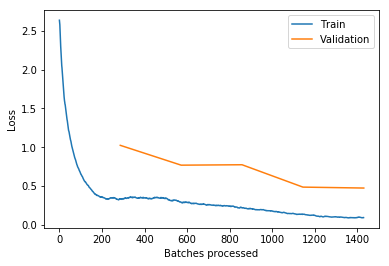

In [11]:
learn.recorder.plot_losses()

In [12]:
# learn.save(f'stage1-300-5epochs')

## Continue

In [30]:
tfms = get_transforms(do_flip=True, 
                      max_rotate=5, 
                      max_zoom=1.05, 
                      max_lighting=0.3, 
                      max_warp=0,
                      p_affine=0.75,
                      p_lighting=0.8)

In [31]:
data=None
gc.collect()
data = get_data(80,300,tfms)
learn= reset_learner(data,is_fp16=True)

In [24]:
# learn.fit_one_cycle(8,max_lr=8e-03)

In [25]:
# learn.save(f'stage1-300-8epochs')

## stage 2

In [6]:
tfms = get_transforms(do_flip=True, 
                      max_rotate=5, 
                      max_zoom=1.05, 
                      max_lighting=0.3, 
                      max_warp=0,
                      p_affine=0.75,
                      p_lighting=0.8)
data=None
gc.collect()
data = get_data(64,300,tfms)
learn= reset_learner(data,is_fp16=True)

In [7]:
learn.load('stage1-300-8epochs');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


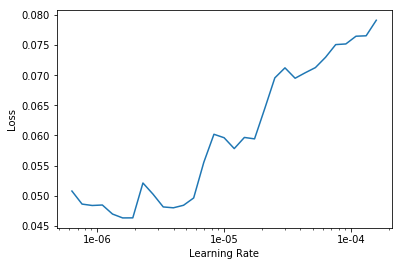

In [37]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


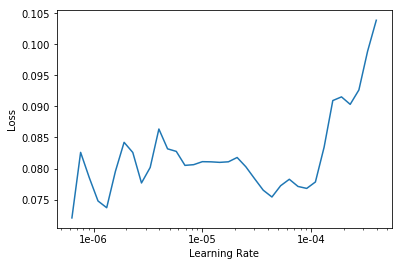

In [44]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


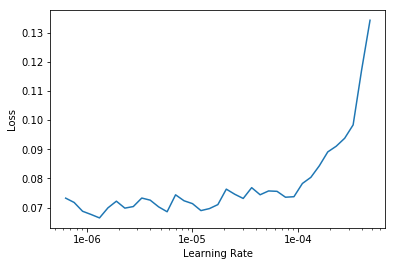

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [46]:
# old_lr = 8e-03
# learn.unfreeze()
# learn.fit_one_cycle(3,max_lr=slice(8e-06,old_lr/5))

In [49]:
# old_lr = 8e-03
# learn.unfreeze()
# learn.fit_one_cycle(5,max_lr=slice(8e-06,old_lr/5))

In [8]:
# old_lr = 8e-03
# learn.unfreeze()
# learn.fit_one_cycle(5,max_lr=slice(1e-05,old_lr/5))

In [50]:
# learn.save(f'stage2-300-5epochs');

# Interpretation

In [4]:
tfms = get_transforms(do_flip=True, 
                      max_rotate=5, 
                      max_zoom=1.05, 
                      max_lighting=0.3, 
                      max_warp=0,
                      p_affine=0.75,
                      p_lighting=0.8)
data=None
gc.collect()
data = get_data(64,300,tfms)
learn= reset_learner(data)
learn.load('stage2-300-5epochs');

In [5]:
# learn.data.valid_dl.add_tfm(to_half)

interp = ClassificationInterpretation.from_learner(learn)

In [6]:
# wrong predictions
interp.most_confused()

[('tarzan', 'beauty', 8),
 ('hercules', 'beauty', 6),
 ('castle', 'kiki', 5),
 ('beauty', 'tarzan', 4),
 ('mononoke', 'kiki', 4),
 ('mulan', 'pocahontas', 4),
 ('howl', 'kiki', 3),
 ('mermaid', 'beauty', 3),
 ('beauty', 'hercules', 2),
 ('castle', 'mulan', 2),
 ('hercules', 'castle', 2),
 ('hercules', 'mermaid', 2),
 ('kiki', 'castle', 2),
 ('mononoke', 'castle', 2),
 ('mulan', 'beauty', 2)]

In [11]:
accuracy(interp.probs,torch.tensor(data.valid_ds.y.items))

tensor(0.8962)

In [82]:
data.classes

['beauty',
 'castle',
 'hercules',
 'howl',
 'kiki',
 'mermaid',
 'mononoke',
 'mulan',
 'pocahontas',
 'tarzan']

In [92]:
def class2idx(clas):
    return data.classes.index(clas)

In [93]:
# act: tarzan/pred: beauty
classes = data.classes
true_idx,pred_idx = class2idx('tarzan'),class2idx('beauty')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
mismatch_idxs

[604, 605, 613, 629, 638, 647, 648, 650]

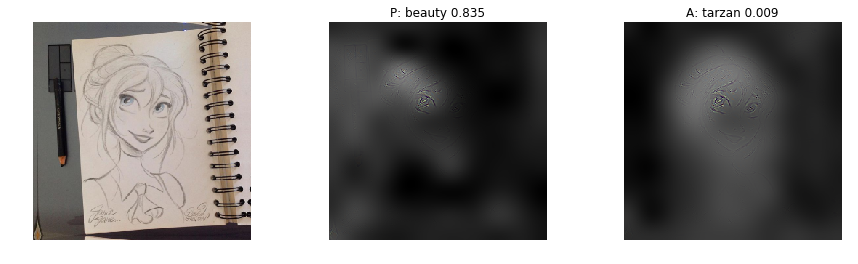

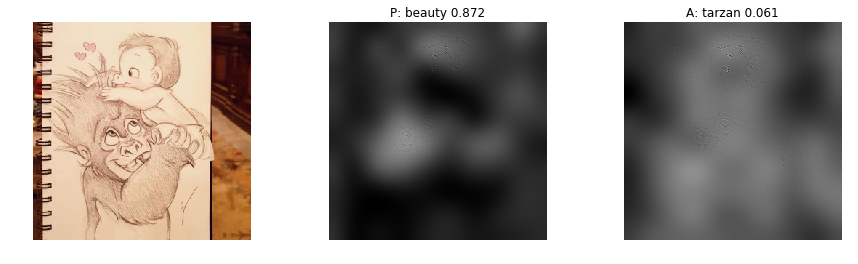

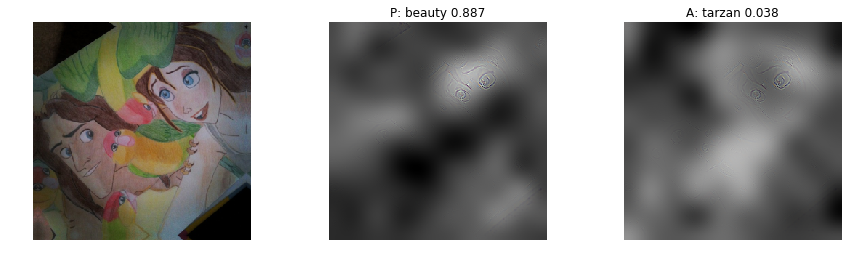

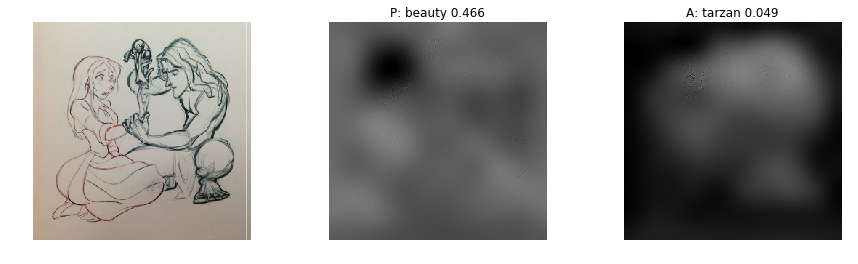

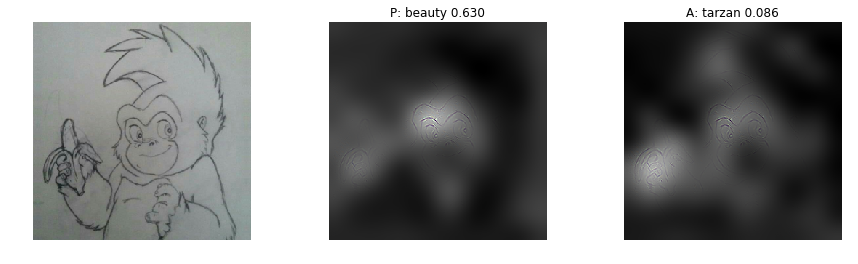

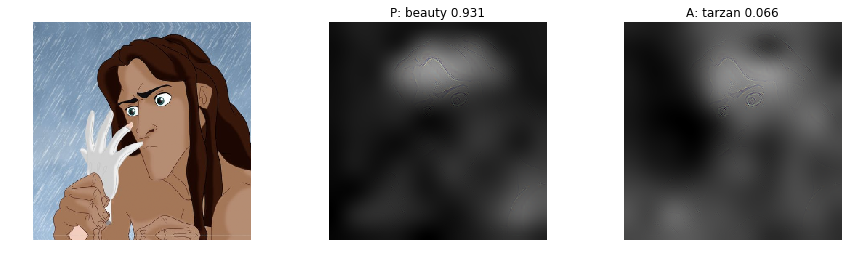

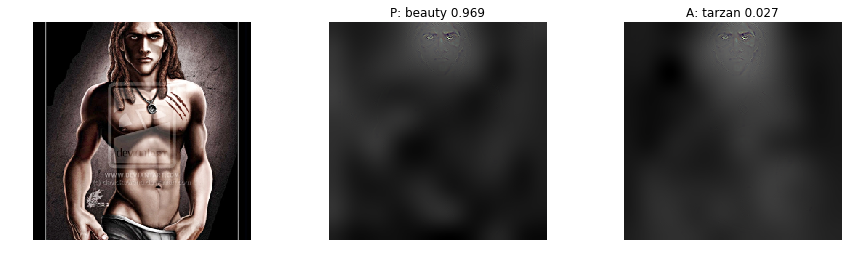

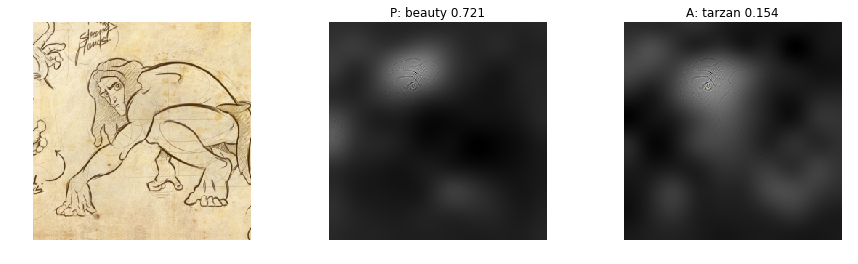

In [83]:
for idx in mismatch_idxs:
    gc = GradCam.from_learner(learn,interp,idx,include_label=True)
    gc.plot(plot_hm=False)

In [84]:

true_idx,pred_idx = class2idx('hercules'),class2idx('beauty')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
mismatch_idxs

[270, 272, 302, 318, 321, 329]

[495, 511, 512, 516, 521]


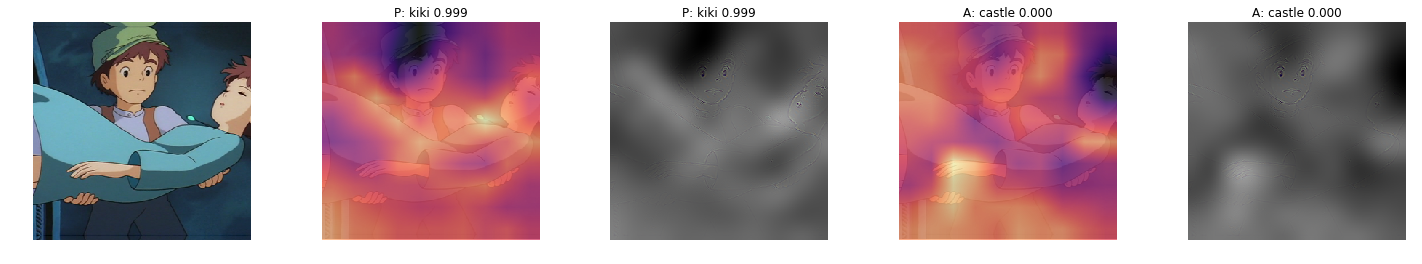

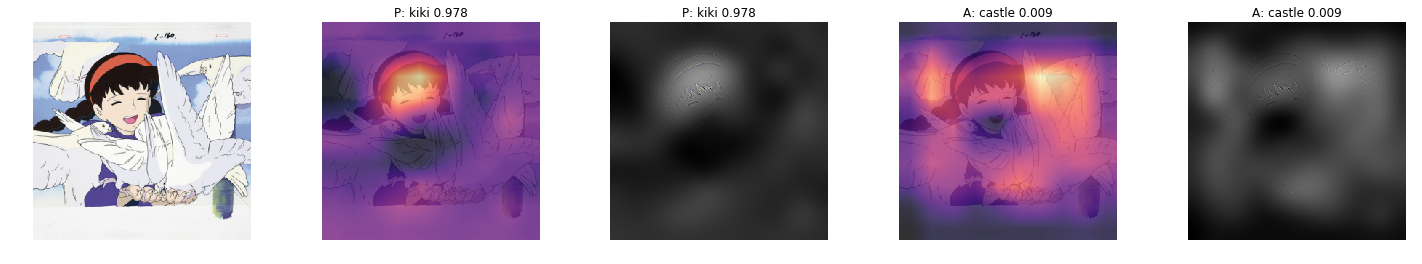

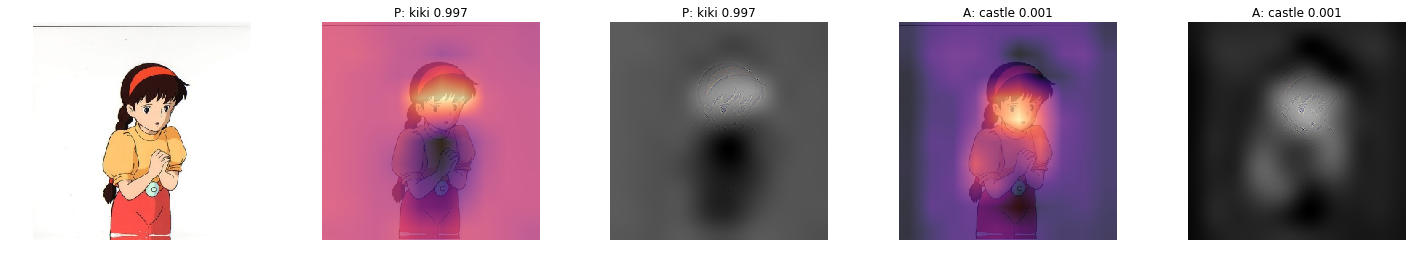

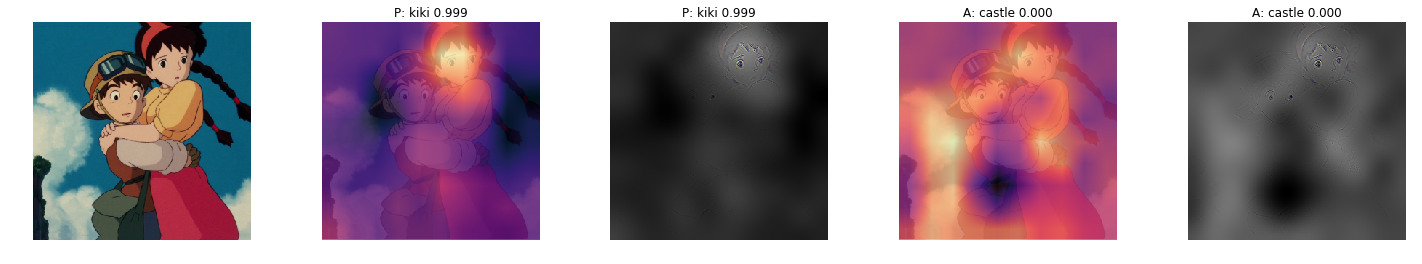

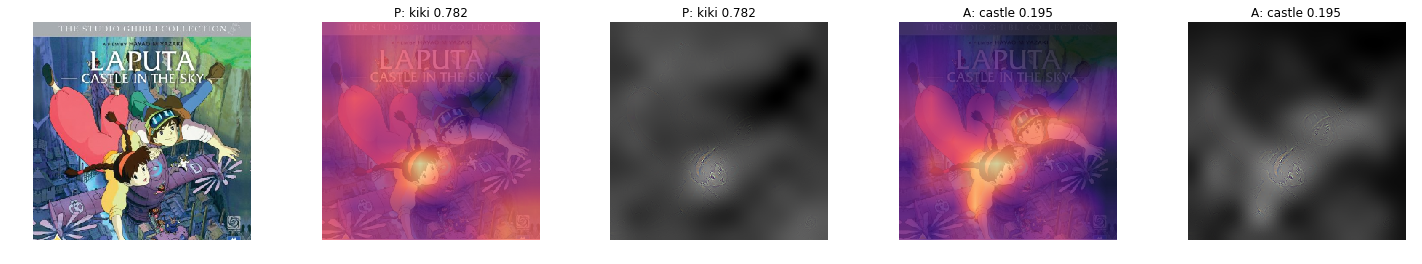

In [94]:

true_idx,pred_idx = class2idx('castle'),class2idx('kiki')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
print(mismatch_idxs)

for idx in mismatch_idxs:
    gc = GradCam.from_learner(learn,interp,idx,include_label=True)
    gc.plot()

[510, 528]


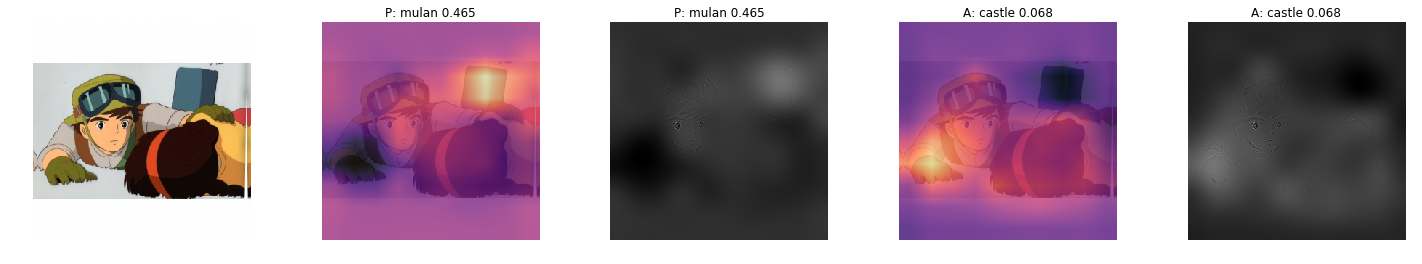

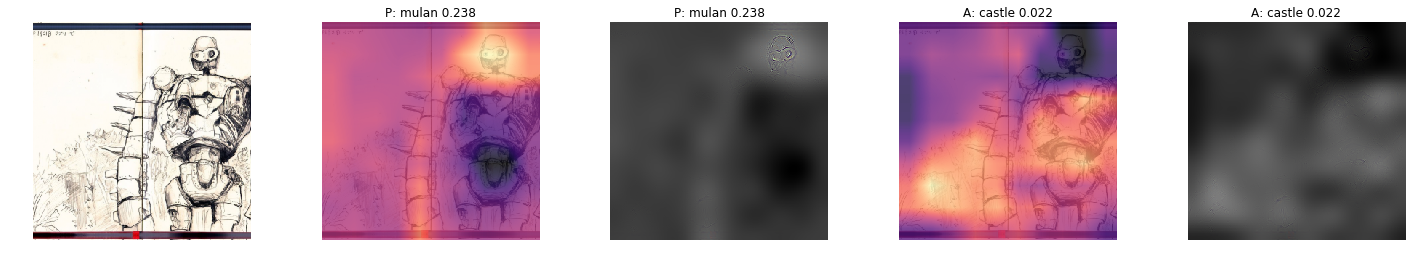

In [95]:
true_idx,pred_idx = class2idx('castle'),class2idx('mulan')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
print(mismatch_idxs)

for idx in mismatch_idxs:
    gc = GradCam.from_learner(learn,interp,idx,include_label=True)
    gc.plot()

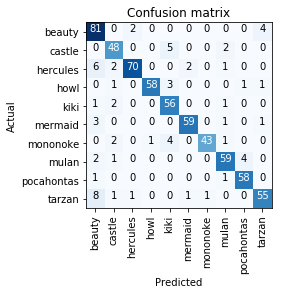

In [54]:
interp.plot_confusion_matrix()

# Test

In [61]:
tfms = get_transforms(do_flip=True, 
                      max_rotate=5, 
                      max_zoom=1.05, 
                      max_lighting=0.3, 
                      max_warp=0,
                      p_affine=0.75,
                      p_lighting=0.8)
data=None
gc.collect()
data= ImageDataBunch.from_folder(PATH,train='train',valid='test',bs=64,ds_tfms = tfms,size=300,num_workers=4).normalize(imagenet_stats)
learn= reset_learner(data)
learn.load('stage2-300-5epochs');


In [62]:
interp = ClassificationInterpretation.from_learner(learn)

accuracy(interp.probs,torch.tensor(data.valid_ds.y.items))

tensor(0.6560)